# Телеком. Прогнозирование оттока клиентов

## Описание проекта
Оператору связи необходимо построить модель машинного обучения для прогнозирования оттока клиентов. В нашем распоряжении имеются персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
Информация о договорах актуальна на 1 февраля 2020.

- Основная метрика для проверки качества модели: **roc_auc не ниже 0.85**
- Random_state = **190623**

## Описание услуг
Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

## Описание данных
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

# Исследовательский анализ данных

### Импорт библиотек

In [1]:
!install scikit-learn==1.1.3

usage: install [-bCcpSsv] [-B suffix] [-f flags] [-g group] [-m mode]
               [-o owner] file1 file2
       install [-bCcpSsv] [-B suffix] [-f flags] [-g group] [-m mode]
               [-o owner] file1 ... fileN directory
       install -d [-v] [-g group] [-m mode] [-o owner] directory ...


In [2]:
# исследовательский анализ данных
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# обучение модели
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from sklearn.metrics import confusion_matrix

# настройки
import warnings
warnings.filterwarnings('ignore')

# зафиксируем Random_state для всего ноутбука
RANDOM_STATE = 190623

### Загрузка данных

In [3]:
try:
    contract = pd.read_csv('Datasets/contract_new.csv', index_col='customerID')
    internet = pd.read_csv('Datasets/internet_new.csv', index_col='customerID')
    personal = pd.read_csv('Datasets/personal_new.csv', index_col='customerID')
    phone = pd.read_csv('Datasets/phone_new.csv', index_col='customerID')
except:
    contract = pd.read_csv('/datasets/contract_new.csv', index_col='customerID')
    internet = pd.read_csv('/datasets/internet_new.csv', index_col='customerID')
    personal = pd.read_csv('/datasets/personal_new.csv', index_col='customerID')
    phone = pd.read_csv('/datasets/phone_new.csv', index_col='customerID')

### Информация о договоре

In [4]:
contract.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


In [6]:
# изменим тип данных, чтобы можно было вывести describe для столбца TotalCharges

contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract.dtypes

BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

In [7]:
contract.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2118.621822
std,30.090047,2112.736199
min,18.250000,19.050000
25%,35.500000,439.745000
50%,70.350000,1345.275000
75%,89.850000,3239.317500
max,118.750000,9221.380000


In [8]:
contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [9]:
contract['BeginDate'].sort_values().unique()

array(['2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01',
       '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01',
       '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01',
       '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01',
       '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01',
       '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01',
       '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
       '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
       '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
       '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
       '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
       '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
       '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
       '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-

**Вывод:**

Общее количество строк в датасете 7043, количество столбцов 8. 

Содержатся данные:
- customerID - ID клиента;
- BeginDate - дата начала пользования услугами;
- EndDate - дата окончания пользования услугами
- Type - тип договора (ежемесячная оплата, за год или два года);
- PaperlessBilling - 	факт выставления счета на эл-ую почту;
- PaymentMethod - способ оплаты;
- MonthlyCharges - ежемесячные траты на услуги;
- TotalCharges - всего потрачено денег на услуги.

Пропусков не обнаружено. 

Данные с 01.10.2013 года.

### Информация о персональных данных клиента

In [10]:
personal.head()

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [11]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


**Вывод:**

Общее количество строк в датасете 7043, количество столбцов 5.

Содержатся данные:
- customerID - ID клиента;
- gender - пол клиента;
- SeniorCitizen - пенсионер;
- Partner - наличие партнера;
- Dependents - наличие иждивенцев.

Пропусков в данных не обнаружено.

### Информация об интернет-услугах

In [12]:
internet.head()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [13]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


**Вывод:**

Общее количество строк в датасете 5517, количество столбцов 8.

Содержатся данные:
- customerID - ID клиента;
- InternetService - тип подключения интернета;
- OnlineSecurity - блокировка небезопасных сайтов;
- OnlineBackup - облачное хранилища;	
- DeviceProtection - антивирус;
- TechSupport - техническая поддержка;
- StreamingTV - стриминговое телевидение;
- StreamingMovies - каталог фильмов.

Пропусков в данных не обнаружено.

### Информация об услугах телефонии

In [14]:
phone.head()

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [15]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [16]:
phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

**Вывод:**

Общее количество строк в датасете 6361, количество столбцов 2.

Содержатся данные:
- customerID - ID клиента;
- MultipleLines - наличие возможности ведения параллельных линий во время звонка.

Пропусков в данных не обнаружено.

### Общий вывод:

- датасеты contract и personal содержат 7043 объекта, internet - 5517 объект, и phone 6361 - из них 2971 пользователей активировали услугу;
- не все клиенты одновременно пользуются интернет-услугами и услугами телефонии;
- в датасете данные с 2013-10-01 по 2020-02-01.

## Объединение таблиц

In [17]:
all_data = contract.join([personal, internet, phone])

# проверим размер массива после объединения
print('Размер объединенного датасета:', all_data.shape)

# выведем первые 5 строк объединенного датасета
all_data.head()

Размер объединенного датасета: (7043, 19)


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


## План работы

- Предобработка данных (работа с пропусками,  приведение наименований столбцов к одному виду и нижнему регистру, удаление столбцов не влияющих на обучение модели, создание новых признаков);
- Изучим соотношение классов ушедших клиентов и текущих;
- Разделение на обучающую и тестовую выборки;
- Кодирование данных;
- Построение не менее 3 моделей;
- Подбор оптимальных значений гиперпараметров моделей;
- Оценка качества лучшей модели на тестовой выборке;
- Анализ лучшей модели;
- Составление отчета по проделанной работе и полученными результатам.

## Предобработка данных

In [18]:
all_data.head(2)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No


In [19]:
# разделим слова в наименовании столбцов для удобства восприятия

all_data.columns = all_data.columns.str.replace('(?<=[a-zA-Z])([A-Z])', '_' + '\g<1>')                       
                        
# приведем столбцы к нижнему регистру
all_data.columns = all_data.columns.str.lower()
all_data.columns.tolist()

['begin_date',
 'end_date',
 'type',
 'paperless_billing',
 'payment_method',
 'monthly_charges',
 'total_charges',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_t_v',
 'streaming_movies',
 'multiple_lines']

In [20]:
all_data.head(2)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No


In [21]:
all_data.dtypes

begin_date            object
end_date              object
type                  object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges        float64
gender                object
senior_citizen         int64
partner               object
dependents            object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_t_v         object
streaming_movies      object
multiple_lines        object
dtype: object

In [22]:
# поменяем тип данных

all_data['begin_date'] = all_data['begin_date'].astype('datetime64')
all_data['begin_date'].head(2)

customerID
7590-VHVEG   2020-01-01
5575-GNVDE   2017-04-01
Name: begin_date, dtype: datetime64[ns]

In [23]:
# проверим есть ли расторгнутые договоры в день выгрузки датасета - 2020-02-01

len(all_data[all_data['end_date']=='2020-02-01'])

0

In [24]:
# заменим пропуски в столбце с end_date на дату дня выгрузки датасета

UPLOAD_DATE = '2020-02-01'
all_data.loc[all_data['end_date'] == 'No', 'end_date'] = UPLOAD_DATE
all_data['end_date'] = all_data['end_date'].astype('datetime64')
all_data['end_date'].head(2)

customerID
7590-VHVEG   2020-02-01
5575-GNVDE   2020-02-01
Name: end_date, dtype: datetime64[ns]

In [25]:
# определим, в каких столбцах есть пропуски

all_data.isna().sum().sort_values()

begin_date              0
dependents              0
senior_citizen          0
gender                  0
monthly_charges         0
partner                 0
paperless_billing       0
type                    0
end_date                0
payment_method          0
total_charges          11
multiple_lines        682
streaming_movies     1526
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_t_v        1526
dtype: int64

In [26]:
# посмотрим пропуски в процентах

all_data.isnull().sum().sort_values()/all_data.shape[0]*100

begin_date            0.000000
dependents            0.000000
senior_citizen        0.000000
gender                0.000000
monthly_charges       0.000000
partner               0.000000
paperless_billing     0.000000
type                  0.000000
end_date              0.000000
payment_method        0.000000
total_charges         0.156183
multiple_lines        9.683374
streaming_movies     21.666903
internet_service     21.666903
online_security      21.666903
online_backup        21.666903
device_protection    21.666903
tech_support         21.666903
streaming_t_v        21.666903
dtype: float64

''

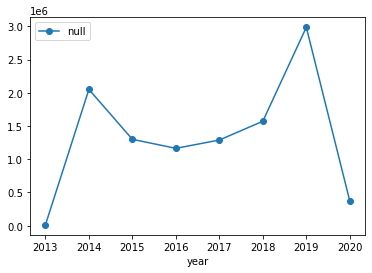

In [27]:
# посмотрим в каких годах больше всего пропусков

all_data['year'] = all_data['begin_date'].dt.year

all_data['null'] = all_data['streaming_movies'].isna().sum()
(
all_data.pivot_table(index = 'year', values = 'null', aggfunc = 'sum')
    .plot(style='o-')
)
;

При первоначальном рассмотрении датасета не было выявлено пропусков, соответственно, они появились после объединения таблиц. Большое и одинаковое количество пропусков в интернет-сервисах, гипотетически, свидетельствует о том, что этим клиентам не предлагали интернет-услуг, или они сами не захотели подключать. 

In [28]:
# проверим в каких строках пропущенные значения столбца total_charges
all_data[all_data['total_charges'].isnull()]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,year,null
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,...,DSL,Yes,No,Yes,Yes,Yes,No,NaN,2020,1526
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,2020,1526
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,2020,1526
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,2020,1526
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,...,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,2020,1526
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,2020,1526
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,2020,1526
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,2020,1526
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,2020,1526


Из выведенной таблицы можно предположить, что значения в столбце total_charges отстуствуют, так как клиенты только первый месяц пользуются услугами. Заменим пропущенные значения столбца total_charges значениями из столбца monthly_charges.

In [29]:
all_data['total_charges'] = all_data['total_charges'].fillna(all_data['monthly_charges'])

In [30]:
# проверим правильно ли заполнились пропуски на рандомной строке
all_data[all_data.index == '2775-SEFEE']

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,year,null
customerID,,,,,,,,,,,,,,,,,,,,,
2775-SEFEE,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),61.9,61.9,Male,0,No,...,DSL,Yes,Yes,No,Yes,No,No,Yes,2020,1526


In [31]:
# пропуски в оставшихся столбцах заменим на 'No', так как клиенты не пользуются этими услугами

all_data.fillna('No', inplace = True)

In [32]:
# проверим, остались ли пропуски в датасете

all_data.isna().sum().sort_values()

begin_date           0
multiple_lines       0
streaming_movies     0
streaming_t_v        0
tech_support         0
device_protection    0
online_backup        0
online_security      0
internet_service     0
year                 0
dependents           0
senior_citizen       0
gender               0
total_charges        0
monthly_charges      0
payment_method       0
paperless_billing    0
type                 0
end_date             0
partner              0
null                 0
dtype: int64

In [33]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   object        
 13  online_backup      7043 non-null   object        
 14

In [34]:
# сбросим индекс с customerID
all_data.reset_index(drop= True , inplace= True )
all_data.head(2)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,year,null
0,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,DSL,No,Yes,No,No,No,No,No,2020,1526
1,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,DSL,Yes,No,Yes,No,No,No,No,2017,1526


**Вывод:**

- разделили слова в наименовании столбцов для удобства восприятия;
- привели столбцы к нижнему регистру;
- поменяли тип данных в столбцах:
    begin_date и end_date с object на datetime64,
    total_charges с object на float64;
- заменили пропуски в столбце end_date на дату дня выгрузки датасета;
- пропуски в оставшихся столбцах заменили на 'No';
- заменили пропущенные значения столбца total_charges на значения из тех же строк столбца monthly_charges;
- сбросили индекс столбца customerID на классический. 

### Создание новых признаков

In [35]:
# Рассчитаем количество дней, в течение которых клиент пользовался услугами компании
all_data['duration_days'] = (all_data['end_date'] - all_data['begin_date']).dt.days

# Продолжает ли клиент пользоваться услугами оператора
all_data['current_client'] = all_data['end_date'] != all_data['end_date'].max() 

# Проверим создание новых признаков
all_data.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,year,null,duration_days,current_client
0,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,Yes,No,No,No,No,No,2020,1526,31,False
1,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,No,Yes,No,No,No,No,2017,1526,1036,False
2,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,Yes,No,No,No,No,No,2019,1526,123,False
3,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,...,No,Yes,Yes,No,No,No,2016,1526,1371,False
4,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,...,No,No,No,No,No,No,2019,1526,153,False


In [36]:
all_data['current_client'].value_counts()

False    5942
True     1101
Name: current_client, dtype: int64

In [37]:
# удаляем столбцы не влияющие на обучение модели
all_data = all_data.drop(['begin_date', 'end_date', 'year', 'null'], axis=1)
all_data.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,duration_days,current_client
0,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31,False
1,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036,False
2,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,123,False
3,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371,False
4,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,153,False


### Выделение признаков и целевого признака

In [38]:
features = all_data.drop(columns=['current_client'])
target = all_data['current_client']

In [39]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   int64  
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_t_v      7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines     7043 

In [40]:
target.info()

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: current_client
Non-Null Count  Dtype
--------------  -----
7043 non-null   bool 
dtypes: bool(1)
memory usage: 7.0 KB


### Разделение на тренировочную и тестовую выборки

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

In [42]:
X_train.shape

(5282, 18)

In [43]:
X_test.shape

(1761, 18)

### Кодирование признаков

Для категориальных признаков будем использовать технику прямого кодирования OHE, и StandardScaler для численных признаков.

In [44]:
# список категориальных столбцов

ohe_columns = X_train.select_dtypes(include='object').columns.to_list()
ohe_columns

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_t_v',
 'streaming_movies',
 'multiple_lines']

In [45]:
# список численных столбцов

num_columns = X_train.select_dtypes(exclude='object').columns.to_list()
num_columns.remove('senior_citizen')
num_columns

['monthly_charges', 'total_charges', 'duration_days']

In [46]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(X_train[ohe_columns])

# добавляем закодированные признаки в X_train_ohe
X_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_train[ohe_columns])

# удаляем незакодированные категориальные признаки
X_train = X_train.drop(ohe_columns, axis=1)

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки
X_train[num_columns] = scaler.fit_transform(X_train[num_columns])

# смотрим на результат
X_train.head()

,monthly_charges,total_charges,senior_citizen,duration_days,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,...,dependents_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_t_v_Yes,streaming_movies_Yes,multiple_lines_Yes
2298,0.500345,1.785747,0,1.764395,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4028,1.495798,2.342269,0,1.495149,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1587,-1.254970,-0.540787,0,0.201594,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
669,-0.209745,0.519665,0,1.050306,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1791,-0.086972,0.291348,0,0.649363,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


###  RandomForestRegressor

In [47]:
X_train_rf =  X_train.copy()
X_test_rf = X_test.copy()

In [48]:
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

param_grid_rf = {
    'n_estimators': range(50, 251, 50),
    'max_depth': range(2, 15),
    'min_samples_split': (2, 3, 4),
    'min_samples_leaf': (1, 2, 3, 4)
}

gs_rf = RandomizedSearchCV(
    estimator = model_rf, 
    param_distributions=param_grid_rf, 
    scoring='roc_auc', 
    n_jobs=-1, 
    random_state=RANDOM_STATE
)

gs_rf.fit(X_train_rf, y_train)

gs_rf_best_score = gs_rf.best_score_
gs_rf_best_params = gs_rf.best_params_
print(f'best_score: {gs_rf_best_score}')
print(f'best_params: {gs_rf_best_params}')

best_score: 0.8319548172519029
best_params: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 7}


**Вывод:**

Модель **RandomForestRegressor** показала результат метрики на обучающей выборке

**ROC-AUC = 0.83**

со следующими параметрами: 
- n_estimators': 200, 
- 'min_samples_split': 4, 
- 'min_samples_leaf': 1, 
- 'max_depth': 7

### LogisticRegression

In [49]:
X_train_lr =  X_train.copy()
X_test_lr = X_test.copy()

In [50]:
model_lr = LogisticRegression(random_state=RANDOM_STATE)


# словарь с гиперпараметрами
param_grid_lr = {
    'solver' : ['saga'],
    'max_iter' : [200, 300, 100],
    'C': np.geomspace(1e-4, 1000, 1000)
}

gs_lr = GridSearchCV(
    estimator = model_lr,
    param_grid=param_grid_lr, 
    scoring='roc_auc', 
    n_jobs=-1
)

gs_lr.fit(X_train_lr, y_train)

gs_lr_best_score = gs_lr.best_score_
gs_lr_best_params = gs_lr.best_params_

# лучшее значение ROC-AUC
print(f'best_score: {gs_lr.best_score_}')

# лучшие гиперпараметры
print(f'best_params: {gs_lr.best_params_}')

best_score: 0.7673871479999252
best_params: {'C': 10.91535935331391, 'max_iter': 200, 'solver': 'saga'}


**Вывод:**

Модель **LogisticRegression** показала результат метрики на обучающей выборке

**ROC-AUC = 0.77**

со следующими параметрами: 
- 'C': 10.91535935331391, 
- 'max_iter': 200, 
- 'solver': 'saga'

### CatBoostClassifier

In [51]:
X_train_cb =  X_train.copy()
X_test_cb = X_test.copy()

In [52]:
model_cb = CatBoostClassifier(random_state=RANDOM_STATE)


# словарь с гиперпараметрами
param_grid_cb = {
    'n_estimators': range(100, 300, 200),
    'max_depth': range(2, 15),
    'learning_rate': [0,1]
}

gs_cb = GridSearchCV(
    estimator = model_cb,
    param_grid=param_grid_cb, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=False
)

gs_cb.fit(X_train_cb, y_train)

gs_cb_best_score = gs_cb.best_score_
gs_cb_best_params = gs_cb.best_params_

# лучшее значение ROC-AUC
print(f'best_score: {gs_cb.best_score_}')

# лучшие гиперпараметры
print(f'best_params: {gs_cb.best_params_}')

0:	learn: 0.4069611	total: 50.7ms	remaining: 5.01s
1:	learn: 0.3830898	total: 51.8ms	remaining: 2.54s
2:	learn: 0.3725347	total: 53.1ms	remaining: 1.72s
3:	learn: 0.3576049	total: 54.5ms	remaining: 1.31s
4:	learn: 0.3456386	total: 55.6ms	remaining: 1.06s
5:	learn: 0.3392772	total: 56.7ms	remaining: 888ms
6:	learn: 0.3320552	total: 58ms	remaining: 770ms
7:	learn: 0.3290259	total: 58.7ms	remaining: 675ms
8:	learn: 0.3256384	total: 59.6ms	remaining: 603ms
9:	learn: 0.3235151	total: 60.6ms	remaining: 545ms
10:	learn: 0.3216780	total: 62.1ms	remaining: 502ms
11:	learn: 0.3206281	total: 63.5ms	remaining: 466ms
12:	learn: 0.3168365	total: 64.5ms	remaining: 432ms
13:	learn: 0.3155115	total: 65.5ms	remaining: 402ms
14:	learn: 0.3135865	total: 66.5ms	remaining: 377ms
15:	learn: 0.3115941	total: 67.6ms	remaining: 355ms
16:	learn: 0.3089836	total: 68.5ms	remaining: 334ms
17:	learn: 0.3062741	total: 69.5ms	remaining: 316ms
18:	learn: 0.3053218	total: 70.7ms	remaining: 301ms
19:	learn: 0.3029990	tot

38:	learn: 0.2590743	total: 95.1ms	remaining: 149ms
39:	learn: 0.2567581	total: 96.2ms	remaining: 144ms
40:	learn: 0.2534022	total: 97.1ms	remaining: 140ms
41:	learn: 0.2523740	total: 98.1ms	remaining: 135ms
42:	learn: 0.2500592	total: 99.2ms	remaining: 132ms
43:	learn: 0.2472397	total: 100ms	remaining: 128ms
44:	learn: 0.2462836	total: 101ms	remaining: 124ms
45:	learn: 0.2443574	total: 104ms	remaining: 122ms
46:	learn: 0.2421427	total: 105ms	remaining: 119ms
47:	learn: 0.2417234	total: 106ms	remaining: 115ms
48:	learn: 0.2405521	total: 108ms	remaining: 113ms
49:	learn: 0.2375563	total: 109ms	remaining: 109ms
50:	learn: 0.2360051	total: 111ms	remaining: 106ms
51:	learn: 0.2334271	total: 112ms	remaining: 104ms
52:	learn: 0.2279213	total: 114ms	remaining: 101ms
53:	learn: 0.2233213	total: 115ms	remaining: 97.7ms
54:	learn: 0.2228057	total: 117ms	remaining: 95.8ms
55:	learn: 0.2171620	total: 118ms	remaining: 92.9ms
56:	learn: 0.2140643	total: 119ms	remaining: 89.9ms
57:	learn: 0.2119017	t

0:	learn: 0.4075602	total: 51.9ms	remaining: 5.14s
1:	learn: 0.3744832	total: 53.2ms	remaining: 2.61s
2:	learn: 0.3584313	total: 54.3ms	remaining: 1.76s
3:	learn: 0.3460667	total: 55.4ms	remaining: 1.33s
4:	learn: 0.3400285	total: 56.5ms	remaining: 1.07s
5:	learn: 0.3355677	total: 57.5ms	remaining: 901ms
6:	learn: 0.3317078	total: 58.9ms	remaining: 782ms
7:	learn: 0.3293136	total: 60.1ms	remaining: 691ms
8:	learn: 0.3222448	total: 61.5ms	remaining: 621ms
9:	learn: 0.3185107	total: 62.9ms	remaining: 566ms
10:	learn: 0.3164517	total: 64.5ms	remaining: 522ms
11:	learn: 0.3107178	total: 65.7ms	remaining: 482ms
12:	learn: 0.3059667	total: 67.3ms	remaining: 450ms
13:	learn: 0.3036794	total: 68.6ms	remaining: 421ms
14:	learn: 0.3009569	total: 69.8ms	remaining: 396ms
15:	learn: 0.2982509	total: 71ms	remaining: 373ms
16:	learn: 0.2917831	total: 72.5ms	remaining: 354ms
17:	learn: 0.2891400	total: 73.7ms	remaining: 336ms
18:	learn: 0.2842733	total: 75ms	remaining: 320ms
19:	learn: 0.2803175	total

0:	learn: 0.4021504	total: 52.5ms	remaining: 5.2s
1:	learn: 0.3693399	total: 53.7ms	remaining: 2.63s
2:	learn: 0.3521933	total: 54.7ms	remaining: 1.77s
3:	learn: 0.3398116	total: 55.9ms	remaining: 1.34s
4:	learn: 0.3373338	total: 57.2ms	remaining: 1.09s
5:	learn: 0.3309121	total: 58.5ms	remaining: 916ms
6:	learn: 0.3239216	total: 59.8ms	remaining: 795ms
7:	learn: 0.3177487	total: 61.2ms	remaining: 704ms
8:	learn: 0.3159782	total: 62.5ms	remaining: 632ms
9:	learn: 0.3109360	total: 63.8ms	remaining: 574ms
10:	learn: 0.3086640	total: 65.1ms	remaining: 526ms
11:	learn: 0.3058751	total: 66.5ms	remaining: 488ms
12:	learn: 0.3029452	total: 67.9ms	remaining: 454ms
13:	learn: 0.2987782	total: 69.2ms	remaining: 425ms
14:	learn: 0.2927331	total: 70.6ms	remaining: 400ms
15:	learn: 0.2882718	total: 71.9ms	remaining: 377ms
16:	learn: 0.2864243	total: 73.4ms	remaining: 358ms
17:	learn: 0.2823968	total: 74.8ms	remaining: 341ms
18:	learn: 0.2809121	total: 76.2ms	remaining: 325ms
19:	learn: 0.2756961	to

0:	learn: 0.3934589	total: 51.4ms	remaining: 5.08s
1:	learn: 0.3607969	total: 52.5ms	remaining: 2.57s
2:	learn: 0.3461596	total: 53.6ms	remaining: 1.73s
3:	learn: 0.3353157	total: 54.8ms	remaining: 1.31s
4:	learn: 0.3280610	total: 55.9ms	remaining: 1.06s
5:	learn: 0.3260796	total: 57.3ms	remaining: 897ms
6:	learn: 0.3229288	total: 58.7ms	remaining: 780ms
7:	learn: 0.3185088	total: 60ms	remaining: 690ms
8:	learn: 0.3164205	total: 61.4ms	remaining: 621ms
9:	learn: 0.3093500	total: 62.7ms	remaining: 564ms
10:	learn: 0.3074310	total: 64.2ms	remaining: 519ms
11:	learn: 0.3022245	total: 65.5ms	remaining: 480ms
12:	learn: 0.2998704	total: 66.8ms	remaining: 447ms
13:	learn: 0.2987499	total: 68ms	remaining: 418ms
14:	learn: 0.2970876	total: 69.3ms	remaining: 393ms
15:	learn: 0.2908079	total: 70.6ms	remaining: 371ms
16:	learn: 0.2886003	total: 71.8ms	remaining: 351ms
17:	learn: 0.2852872	total: 73ms	remaining: 333ms
18:	learn: 0.2840728	total: 74.3ms	remaining: 317ms
19:	learn: 0.2789773	total: 

19:	learn: 0.1510009	total: 394ms	remaining: 1.57s
20:	learn: 0.1429737	total: 414ms	remaining: 1.55s
21:	learn: 0.1372015	total: 430ms	remaining: 1.52s
22:	learn: 0.1317426	total: 450ms	remaining: 1.51s
23:	learn: 0.1271441	total: 468ms	remaining: 1.48s
24:	learn: 0.1235808	total: 487ms	remaining: 1.46s
25:	learn: 0.1187050	total: 499ms	remaining: 1.42s
26:	learn: 0.1128413	total: 525ms	remaining: 1.42s
27:	learn: 0.1064639	total: 541ms	remaining: 1.39s
28:	learn: 0.1021328	total: 559ms	remaining: 1.37s
29:	learn: 0.1008157	total: 579ms	remaining: 1.35s
30:	learn: 0.0973984	total: 601ms	remaining: 1.34s
31:	learn: 0.0930846	total: 616ms	remaining: 1.31s
32:	learn: 0.0892166	total: 637ms	remaining: 1.29s
33:	learn: 0.0866716	total: 654ms	remaining: 1.27s
34:	learn: 0.0835907	total: 670ms	remaining: 1.24s
35:	learn: 0.0800117	total: 692ms	remaining: 1.23s
36:	learn: 0.0769459	total: 709ms	remaining: 1.21s
37:	learn: 0.0739258	total: 735ms	remaining: 1.2s
38:	learn: 0.0710637	total: 753m

0:	learn: 0.4040545	total: 51.2ms	remaining: 5.07s
1:	learn: 0.3647817	total: 52.9ms	remaining: 2.59s
2:	learn: 0.3447067	total: 54.5ms	remaining: 1.76s
3:	learn: 0.3374440	total: 56.1ms	remaining: 1.35s
4:	learn: 0.3312339	total: 58ms	remaining: 1.1s
5:	learn: 0.3215065	total: 59.5ms	remaining: 932ms
6:	learn: 0.3161264	total: 61.2ms	remaining: 814ms
7:	learn: 0.3122829	total: 62.8ms	remaining: 723ms
8:	learn: 0.3093623	total: 64.2ms	remaining: 649ms
9:	learn: 0.3063461	total: 65.6ms	remaining: 591ms
10:	learn: 0.2955170	total: 67.1ms	remaining: 543ms
11:	learn: 0.2904842	total: 69ms	remaining: 506ms
12:	learn: 0.2873780	total: 71.9ms	remaining: 481ms
13:	learn: 0.2838419	total: 73.7ms	remaining: 453ms
14:	learn: 0.2792782	total: 75.2ms	remaining: 426ms
15:	learn: 0.2724130	total: 76.7ms	remaining: 402ms
16:	learn: 0.2689478	total: 78.1ms	remaining: 382ms
17:	learn: 0.2625993	total: 79.7ms	remaining: 363ms
18:	learn: 0.2556492	total: 82.7ms	remaining: 353ms
19:	learn: 0.2525814	total:

0:	learn: 0.4003212	total: 54.2ms	remaining: 5.36s
1:	learn: 0.3700409	total: 56ms	remaining: 2.74s
2:	learn: 0.3379014	total: 57.5ms	remaining: 1.86s
3:	learn: 0.3264610	total: 59.2ms	remaining: 1.42s
4:	learn: 0.3219056	total: 60.9ms	remaining: 1.16s
5:	learn: 0.3189375	total: 62.6ms	remaining: 981ms
6:	learn: 0.3154067	total: 64.2ms	remaining: 853ms
7:	learn: 0.3123965	total: 65.8ms	remaining: 757ms
8:	learn: 0.3085323	total: 67.4ms	remaining: 681ms
9:	learn: 0.3014541	total: 69.2ms	remaining: 623ms
10:	learn: 0.2945916	total: 70.9ms	remaining: 574ms
11:	learn: 0.2885608	total: 72.7ms	remaining: 533ms
12:	learn: 0.2828647	total: 74.4ms	remaining: 498ms
13:	learn: 0.2752422	total: 76.2ms	remaining: 468ms
14:	learn: 0.2685681	total: 77.9ms	remaining: 441ms
15:	learn: 0.2636798	total: 79.8ms	remaining: 419ms
16:	learn: 0.2600018	total: 81.4ms	remaining: 398ms
17:	learn: 0.2539441	total: 83.3ms	remaining: 379ms
18:	learn: 0.2472305	total: 85.6ms	remaining: 365ms
19:	learn: 0.2431285	tot

0:	learn: 0.3792587	total: 54.2ms	remaining: 5.36s
1:	learn: 0.3470401	total: 56.4ms	remaining: 2.76s
2:	learn: 0.3306209	total: 58.6ms	remaining: 1.9s
3:	learn: 0.3257404	total: 60.7ms	remaining: 1.46s
4:	learn: 0.3206333	total: 62.9ms	remaining: 1.2s
5:	learn: 0.3138551	total: 64.9ms	remaining: 1.02s
6:	learn: 0.3076256	total: 66.7ms	remaining: 886ms
7:	learn: 0.3031311	total: 69.1ms	remaining: 795ms
8:	learn: 0.3004543	total: 71.4ms	remaining: 722ms
9:	learn: 0.2933276	total: 73.9ms	remaining: 665ms
10:	learn: 0.2887732	total: 76.1ms	remaining: 616ms
11:	learn: 0.2800189	total: 78.6ms	remaining: 576ms
12:	learn: 0.2742781	total: 80.8ms	remaining: 541ms
13:	learn: 0.2683130	total: 83.1ms	remaining: 511ms
14:	learn: 0.2608807	total: 85.4ms	remaining: 484ms
15:	learn: 0.2561411	total: 87.8ms	remaining: 461ms
16:	learn: 0.2493223	total: 89.9ms	remaining: 439ms
17:	learn: 0.2445203	total: 92ms	remaining: 419ms
18:	learn: 0.2347105	total: 94ms	remaining: 401ms
19:	learn: 0.2265570	total: 

0:	learn: 0.3856937	total: 54.9ms	remaining: 5.44s
1:	learn: 0.3392172	total: 58.2ms	remaining: 2.85s
2:	learn: 0.3199745	total: 61.4ms	remaining: 1.99s
3:	learn: 0.3090282	total: 64.7ms	remaining: 1.55s
4:	learn: 0.3018343	total: 67.9ms	remaining: 1.29s
5:	learn: 0.2931911	total: 70.8ms	remaining: 1.11s
6:	learn: 0.2889969	total: 74.1ms	remaining: 985ms
7:	learn: 0.2835342	total: 77.2ms	remaining: 888ms
8:	learn: 0.2742450	total: 80.4ms	remaining: 813ms
9:	learn: 0.2692600	total: 83.8ms	remaining: 754ms
10:	learn: 0.2605672	total: 86.6ms	remaining: 700ms
11:	learn: 0.2528028	total: 91.2ms	remaining: 669ms
12:	learn: 0.2452695	total: 97.3ms	remaining: 651ms
13:	learn: 0.2363318	total: 100ms	remaining: 617ms
14:	learn: 0.2323453	total: 103ms	remaining: 586ms
15:	learn: 0.2240027	total: 106ms	remaining: 559ms
16:	learn: 0.2181539	total: 109ms	remaining: 531ms
17:	learn: 0.2121238	total: 111ms	remaining: 507ms
18:	learn: 0.2086159	total: 114ms	remaining: 485ms
19:	learn: 0.2009040	total: 

19:	learn: 0.0946546	total: 670ms	remaining: 2.68s
20:	learn: 0.0890878	total: 710ms	remaining: 2.67s
21:	learn: 0.0851850	total: 743ms	remaining: 2.63s
22:	learn: 0.0826009	total: 779ms	remaining: 2.61s
23:	learn: 0.0800098	total: 810ms	remaining: 2.56s
24:	learn: 0.0748008	total: 833ms	remaining: 2.5s
25:	learn: 0.0723926	total: 870ms	remaining: 2.48s
26:	learn: 0.0680544	total: 903ms	remaining: 2.44s
27:	learn: 0.0656974	total: 932ms	remaining: 2.4s
28:	learn: 0.0629845	total: 963ms	remaining: 2.36s
29:	learn: 0.0602368	total: 1.02s	remaining: 2.38s
30:	learn: 0.0575724	total: 1.05s	remaining: 2.34s
31:	learn: 0.0556205	total: 1.09s	remaining: 2.31s
32:	learn: 0.0527132	total: 1.13s	remaining: 2.29s
33:	learn: 0.0508022	total: 1.16s	remaining: 2.25s
34:	learn: 0.0494570	total: 1.2s	remaining: 2.23s
35:	learn: 0.0474455	total: 1.23s	remaining: 2.19s
36:	learn: 0.0446289	total: 1.27s	remaining: 2.16s
37:	learn: 0.0431900	total: 1.31s	remaining: 2.14s
38:	learn: 0.0413879	total: 1.34s	

19:	learn: 0.0917034	total: 715ms	remaining: 2.86s
20:	learn: 0.0880483	total: 744ms	remaining: 2.8s
21:	learn: 0.0773646	total: 787ms	remaining: 2.79s
22:	learn: 0.0743321	total: 827ms	remaining: 2.77s
23:	learn: 0.0708585	total: 868ms	remaining: 2.75s
24:	learn: 0.0688829	total: 912ms	remaining: 2.74s
25:	learn: 0.0672798	total: 947ms	remaining: 2.7s
26:	learn: 0.0637928	total: 991ms	remaining: 2.68s
27:	learn: 0.0627148	total: 1.01s	remaining: 2.6s
28:	learn: 0.0584331	total: 1.05s	remaining: 2.58s
29:	learn: 0.0574062	total: 1.08s	remaining: 2.52s
30:	learn: 0.0548567	total: 1.12s	remaining: 2.49s
31:	learn: 0.0545848	total: 1.15s	remaining: 2.45s
32:	learn: 0.0532346	total: 1.2s	remaining: 2.44s
33:	learn: 0.0507821	total: 1.24s	remaining: 2.41s
34:	learn: 0.0481200	total: 1.28s	remaining: 2.38s
35:	learn: 0.0453857	total: 1.3s	remaining: 2.31s
36:	learn: 0.0444173	total: 1.36s	remaining: 2.31s
37:	learn: 0.0435726	total: 1.39s	remaining: 2.26s
38:	learn: 0.0418366	total: 1.44s	re

0:	learn: 0.3831867	total: 51.8ms	remaining: 5.13s
1:	learn: 0.3486773	total: 53.8ms	remaining: 2.64s
2:	learn: 0.3307717	total: 55.7ms	remaining: 1.8s
3:	learn: 0.3226437	total: 58ms	remaining: 1.39s
4:	learn: 0.3158241	total: 60.1ms	remaining: 1.14s
5:	learn: 0.3100728	total: 62.3ms	remaining: 976ms
6:	learn: 0.3064491	total: 64.6ms	remaining: 858ms
7:	learn: 0.3002172	total: 66.8ms	remaining: 769ms
8:	learn: 0.2965605	total: 69.1ms	remaining: 698ms
9:	learn: 0.2900766	total: 71.4ms	remaining: 642ms
10:	learn: 0.2847734	total: 73.7ms	remaining: 596ms
11:	learn: 0.2789337	total: 75.5ms	remaining: 554ms
12:	learn: 0.2718737	total: 77.8ms	remaining: 521ms
13:	learn: 0.2667030	total: 80.3ms	remaining: 494ms
14:	learn: 0.2565714	total: 82.6ms	remaining: 468ms
15:	learn: 0.2515407	total: 85ms	remaining: 446ms
16:	learn: 0.2437132	total: 87.3ms	remaining: 426ms
17:	learn: 0.2402481	total: 89.6ms	remaining: 408ms
18:	learn: 0.2333354	total: 91.7ms	remaining: 391ms
19:	learn: 0.2298790	total:

0:	learn: 0.3859239	total: 53.9ms	remaining: 5.34s
1:	learn: 0.3546002	total: 56.3ms	remaining: 2.76s
2:	learn: 0.3290623	total: 58.6ms	remaining: 1.89s
3:	learn: 0.3242206	total: 60.8ms	remaining: 1.46s
4:	learn: 0.3178172	total: 63.1ms	remaining: 1.2s
5:	learn: 0.3124440	total: 65.4ms	remaining: 1.02s
6:	learn: 0.3086611	total: 67.3ms	remaining: 894ms
7:	learn: 0.3048193	total: 69.6ms	remaining: 800ms
8:	learn: 0.2993704	total: 71.8ms	remaining: 726ms
9:	learn: 0.2938504	total: 74ms	remaining: 666ms
10:	learn: 0.2855999	total: 76.6ms	remaining: 619ms
11:	learn: 0.2794759	total: 78.6ms	remaining: 577ms
12:	learn: 0.2752467	total: 81.3ms	remaining: 544ms
13:	learn: 0.2664857	total: 83.6ms	remaining: 514ms
14:	learn: 0.2624230	total: 86.3ms	remaining: 489ms
15:	learn: 0.2562247	total: 88.6ms	remaining: 465ms
16:	learn: 0.2494978	total: 90.5ms	remaining: 442ms
17:	learn: 0.2468373	total: 92.7ms	remaining: 422ms
18:	learn: 0.2439435	total: 97ms	remaining: 414ms
19:	learn: 0.2359577	total:

19:	learn: 0.0745488	total: 1.08s	remaining: 4.31s
20:	learn: 0.0719532	total: 1.15s	remaining: 4.31s
21:	learn: 0.0680201	total: 1.21s	remaining: 4.29s
22:	learn: 0.0665476	total: 1.27s	remaining: 4.26s
23:	learn: 0.0635652	total: 1.34s	remaining: 4.24s
24:	learn: 0.0617025	total: 1.39s	remaining: 4.17s
25:	learn: 0.0584543	total: 1.44s	remaining: 4.09s
26:	learn: 0.0559446	total: 1.51s	remaining: 4.07s
27:	learn: 0.0544448	total: 1.58s	remaining: 4.07s
28:	learn: 0.0486440	total: 1.63s	remaining: 3.99s
29:	learn: 0.0463318	total: 1.69s	remaining: 3.93s
30:	learn: 0.0447633	total: 1.74s	remaining: 3.86s
31:	learn: 0.0429693	total: 1.79s	remaining: 3.8s
32:	learn: 0.0388808	total: 1.83s	remaining: 3.72s
33:	learn: 0.0378873	total: 1.89s	remaining: 3.67s
34:	learn: 0.0369719	total: 1.95s	remaining: 3.63s
35:	learn: 0.0361387	total: 2s	remaining: 3.56s
36:	learn: 0.0355961	total: 2.05s	remaining: 3.49s
37:	learn: 0.0344888	total: 2.12s	remaining: 3.46s
38:	learn: 0.0336656	total: 2.18s	r

19:	learn: 0.0483844	total: 1.41s	remaining: 5.65s
20:	learn: 0.0459306	total: 1.48s	remaining: 5.58s
21:	learn: 0.0444770	total: 1.56s	remaining: 5.54s
22:	learn: 0.0429685	total: 1.66s	remaining: 5.55s
23:	learn: 0.0404851	total: 1.74s	remaining: 5.51s
24:	learn: 0.0375200	total: 1.82s	remaining: 5.45s
25:	learn: 0.0360871	total: 1.89s	remaining: 5.37s
26:	learn: 0.0326839	total: 1.96s	remaining: 5.3s
27:	learn: 0.0311502	total: 2.02s	remaining: 5.21s
28:	learn: 0.0296868	total: 2.1s	remaining: 5.15s
29:	learn: 0.0291226	total: 2.18s	remaining: 5.09s
30:	learn: 0.0283177	total: 2.25s	remaining: 5s
31:	learn: 0.0281573	total: 2.3s	remaining: 4.89s
32:	learn: 0.0271026	total: 2.37s	remaining: 4.81s
33:	learn: 0.0267322	total: 2.44s	remaining: 4.74s
34:	learn: 0.0261060	total: 2.54s	remaining: 4.72s
35:	learn: 0.0252117	total: 2.63s	remaining: 4.68s
36:	learn: 0.0241709	total: 2.69s	remaining: 4.59s
37:	learn: 0.0235508	total: 2.76s	remaining: 4.5s
38:	learn: 0.0227192	total: 2.85s	rema

16:	learn: 0.2008847	total: 190ms	remaining: 927ms
17:	learn: 0.1946885	total: 199ms	remaining: 908ms
18:	learn: 0.1895699	total: 206ms	remaining: 878ms
19:	learn: 0.1806842	total: 221ms	remaining: 884ms
20:	learn: 0.1741378	total: 227ms	remaining: 855ms
21:	learn: 0.1666259	total: 238ms	remaining: 844ms
22:	learn: 0.1626911	total: 248ms	remaining: 830ms
23:	learn: 0.1558510	total: 265ms	remaining: 839ms
24:	learn: 0.1491655	total: 273ms	remaining: 818ms
25:	learn: 0.1451398	total: 283ms	remaining: 807ms
26:	learn: 0.1399919	total: 291ms	remaining: 786ms
27:	learn: 0.1366003	total: 300ms	remaining: 773ms
28:	learn: 0.1300905	total: 310ms	remaining: 760ms
29:	learn: 0.1254160	total: 317ms	remaining: 740ms
30:	learn: 0.1185356	total: 331ms	remaining: 738ms
31:	learn: 0.1138745	total: 347ms	remaining: 738ms
32:	learn: 0.1129623	total: 356ms	remaining: 722ms
33:	learn: 0.1088938	total: 373ms	remaining: 724ms
34:	learn: 0.1050031	total: 384ms	remaining: 713ms
35:	learn: 0.1017542	total: 390

17:	learn: 0.1877607	total: 186ms	remaining: 847ms
18:	learn: 0.1801048	total: 197ms	remaining: 841ms
19:	learn: 0.1713703	total: 220ms	remaining: 880ms
20:	learn: 0.1643165	total: 231ms	remaining: 869ms
21:	learn: 0.1594111	total: 250ms	remaining: 885ms
22:	learn: 0.1542670	total: 256ms	remaining: 858ms
23:	learn: 0.1489574	total: 273ms	remaining: 866ms
24:	learn: 0.1446801	total: 294ms	remaining: 883ms
25:	learn: 0.1408788	total: 308ms	remaining: 877ms
26:	learn: 0.1365515	total: 317ms	remaining: 858ms
27:	learn: 0.1324738	total: 324ms	remaining: 833ms
28:	learn: 0.1277433	total: 341ms	remaining: 835ms
29:	learn: 0.1236274	total: 358ms	remaining: 835ms
30:	learn: 0.1183465	total: 365ms	remaining: 813ms
31:	learn: 0.1154677	total: 378ms	remaining: 802ms
32:	learn: 0.1128075	total: 385ms	remaining: 783ms
33:	learn: 0.1090708	total: 390ms	remaining: 758ms
34:	learn: 0.1063875	total: 400ms	remaining: 743ms
35:	learn: 0.1048053	total: 408ms	remaining: 725ms
36:	learn: 0.1028531	total: 415

20:	learn: 0.0787067	total: 1.34s	remaining: 5.05s
21:	learn: 0.0712587	total: 1.43s	remaining: 5.08s
22:	learn: 0.0668301	total: 1.51s	remaining: 5.05s
23:	learn: 0.0621000	total: 1.58s	remaining: 5.01s
24:	learn: 0.0603591	total: 1.66s	remaining: 4.97s
25:	learn: 0.0581231	total: 1.71s	remaining: 4.87s
26:	learn: 0.0551934	total: 1.79s	remaining: 4.83s
27:	learn: 0.0524549	total: 1.84s	remaining: 4.73s
28:	learn: 0.0501883	total: 1.9s	remaining: 4.64s
29:	learn: 0.0487913	total: 1.97s	remaining: 4.6s
30:	learn: 0.0472142	total: 2.05s	remaining: 4.56s
31:	learn: 0.0455858	total: 2.1s	remaining: 4.46s
32:	learn: 0.0434372	total: 2.19s	remaining: 4.44s
33:	learn: 0.0420438	total: 2.26s	remaining: 4.39s
34:	learn: 0.0409824	total: 2.35s	remaining: 4.37s
35:	learn: 0.0387163	total: 2.46s	remaining: 4.38s
36:	learn: 0.0375099	total: 2.54s	remaining: 4.32s
37:	learn: 0.0361732	total: 2.6s	remaining: 4.24s
38:	learn: 0.0348255	total: 2.71s	remaining: 4.24s
39:	learn: 0.0337195	total: 2.79s	r

17:	learn: 0.1542497	total: 311ms	remaining: 1.42s
18:	learn: 0.1467773	total: 326ms	remaining: 1.39s
19:	learn: 0.1424085	total: 344ms	remaining: 1.38s
20:	learn: 0.1379584	total: 360ms	remaining: 1.35s
21:	learn: 0.1352057	total: 372ms	remaining: 1.32s
22:	learn: 0.1294963	total: 385ms	remaining: 1.29s
23:	learn: 0.1261147	total: 405ms	remaining: 1.28s
24:	learn: 0.1208014	total: 421ms	remaining: 1.26s
25:	learn: 0.1143141	total: 432ms	remaining: 1.23s
26:	learn: 0.1073087	total: 444ms	remaining: 1.2s
27:	learn: 0.1028034	total: 459ms	remaining: 1.18s
28:	learn: 0.0983041	total: 476ms	remaining: 1.17s
29:	learn: 0.0956550	total: 492ms	remaining: 1.15s
30:	learn: 0.0939052	total: 509ms	remaining: 1.13s
31:	learn: 0.0894911	total: 521ms	remaining: 1.11s
32:	learn: 0.0877569	total: 542ms	remaining: 1.1s
33:	learn: 0.0841985	total: 559ms	remaining: 1.08s
34:	learn: 0.0826338	total: 577ms	remaining: 1.07s
35:	learn: 0.0788811	total: 591ms	remaining: 1.05s
36:	learn: 0.0761563	total: 604ms

18:	learn: 0.1363684	total: 382ms	remaining: 1.63s
19:	learn: 0.1313243	total: 400ms	remaining: 1.6s
20:	learn: 0.1203802	total: 422ms	remaining: 1.59s
21:	learn: 0.1167854	total: 443ms	remaining: 1.57s
22:	learn: 0.1133594	total: 475ms	remaining: 1.59s
23:	learn: 0.1076672	total: 514ms	remaining: 1.63s
24:	learn: 0.1030201	total: 529ms	remaining: 1.59s
25:	learn: 0.1010921	total: 545ms	remaining: 1.55s
26:	learn: 0.0971915	total: 568ms	remaining: 1.54s
27:	learn: 0.0930611	total: 586ms	remaining: 1.5s
28:	learn: 0.0904302	total: 601ms	remaining: 1.47s
29:	learn: 0.0877273	total: 618ms	remaining: 1.44s
30:	learn: 0.0858582	total: 633ms	remaining: 1.41s
31:	learn: 0.0832797	total: 656ms	remaining: 1.39s
32:	learn: 0.0792181	total: 673ms	remaining: 1.37s
33:	learn: 0.0732351	total: 692ms	remaining: 1.34s
34:	learn: 0.0702671	total: 712ms	remaining: 1.32s
35:	learn: 0.0661856	total: 731ms	remaining: 1.3s
36:	learn: 0.0633896	total: 747ms	remaining: 1.27s
37:	learn: 0.0608471	total: 761ms	

0:	learn: 0.4167543	total: 56.9ms	remaining: 5.63s
1:	learn: 0.3892738	total: 58.1ms	remaining: 2.85s
2:	learn: 0.3710078	total: 59.1ms	remaining: 1.91s
3:	learn: 0.3556951	total: 60.1ms	remaining: 1.44s
4:	learn: 0.3450698	total: 61ms	remaining: 1.16s
5:	learn: 0.3363623	total: 61.8ms	remaining: 968ms
6:	learn: 0.3336760	total: 62.8ms	remaining: 834ms
7:	learn: 0.3309442	total: 63.8ms	remaining: 734ms
8:	learn: 0.3292894	total: 64.6ms	remaining: 654ms
9:	learn: 0.3274004	total: 65.4ms	remaining: 588ms
10:	learn: 0.3259115	total: 66.1ms	remaining: 534ms
11:	learn: 0.3236353	total: 66.9ms	remaining: 490ms
12:	learn: 0.3221019	total: 67.7ms	remaining: 453ms
13:	learn: 0.3181595	total: 68.7ms	remaining: 422ms
14:	learn: 0.3168243	total: 69.7ms	remaining: 395ms
15:	learn: 0.3159362	total: 70.8ms	remaining: 372ms
16:	learn: 0.3146996	total: 71.8ms	remaining: 351ms
17:	learn: 0.3135004	total: 72.9ms	remaining: 332ms
18:	learn: 0.3120418	total: 73.9ms	remaining: 315ms
19:	learn: 0.3085227	tot

**Вывод:**

Модель **CatBoostClassifier** показала результат метрики на обучающей выборке

**ROC-AUC = 0.91**

со следующими параметрами: 
- 'learning_rate': 1,
- 'max_depth': 2, 
- 'n_estimators': 100

In [53]:
result = pd.DataFrame(
    [gs_rf_best_score, gs_lr_best_score, gs_cb_best_score], 
    index=['RandomForestRegressor', 'LogisticRegression', 'CatBoostClassifier'], 
    columns=['ROC-AUC']
)
result

,ROC-AUC
RandomForestRegressor,0.831955
LogisticRegression,0.767387
CatBoostClassifier,0.907117


Лучший результат показала модель CatBoostClassifier с ROC-AUC = 0.91.

Будем тестировать эту модель.

### Трансформируем тестовую выборку

In [54]:
# кодируем тестовую OHE
X_test_cb[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_test_cb[ohe_columns])

X_test_cb = X_test_cb.drop(ohe_columns, axis=1)

# масштабируем тестовую scaler
X_test_cb[num_columns] = scaler.transform(
    X_test_cb[num_columns]
)

# проверяем
X_test_cb.head(2)

,monthly_charges,total_charges,senior_citizen,duration_days,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,...,dependents_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_t_v_Yes,streaming_movies_Yes,multiple_lines_Yes
4440,-0.136745,0.231407,0,0.605464,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
790,-0.141722,0.814859,0,1.360525,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0


### Проверяем метрику на тестовой выборке

In [55]:
cb_prediction = gs_cb.predict_proba(X_test_cb)
prediction_1 = cb_prediction[:, 1]
metric_test = round(roc_auc_score(y_test, prediction_1), 3)
print(f'ROC-AUC на тестовой выборке : {metric_test}')

ROC-AUC на тестовой выборке : 0.924


**Вывод:** 

Результат модели CatBoostClassifier ROC-AUC на тестовой выборке : 0.924

### Важность признаков лучшей модели

0:	learn: 0.4167543	total: 1.49ms	remaining: 148ms
1:	learn: 0.3892738	total: 2.85ms	remaining: 140ms
2:	learn: 0.3710078	total: 4.2ms	remaining: 136ms
3:	learn: 0.3556951	total: 5.4ms	remaining: 130ms
4:	learn: 0.3450698	total: 6.65ms	remaining: 126ms
5:	learn: 0.3363623	total: 7.89ms	remaining: 124ms
6:	learn: 0.3336760	total: 9.14ms	remaining: 121ms
7:	learn: 0.3309442	total: 10.8ms	remaining: 124ms
8:	learn: 0.3292894	total: 12.1ms	remaining: 123ms
9:	learn: 0.3274004	total: 13.5ms	remaining: 122ms
10:	learn: 0.3259115	total: 14.7ms	remaining: 119ms
11:	learn: 0.3236353	total: 16ms	remaining: 118ms
12:	learn: 0.3221019	total: 17.4ms	remaining: 116ms
13:	learn: 0.3181595	total: 19ms	remaining: 117ms
14:	learn: 0.3168243	total: 20.3ms	remaining: 115ms
15:	learn: 0.3159362	total: 21.8ms	remaining: 115ms
16:	learn: 0.3146996	total: 23ms	remaining: 112ms
17:	learn: 0.3135004	total: 24.5ms	remaining: 112ms
18:	learn: 0.3120418	total: 25.9ms	remaining: 110ms
19:	learn: 0.3085227	total: 27

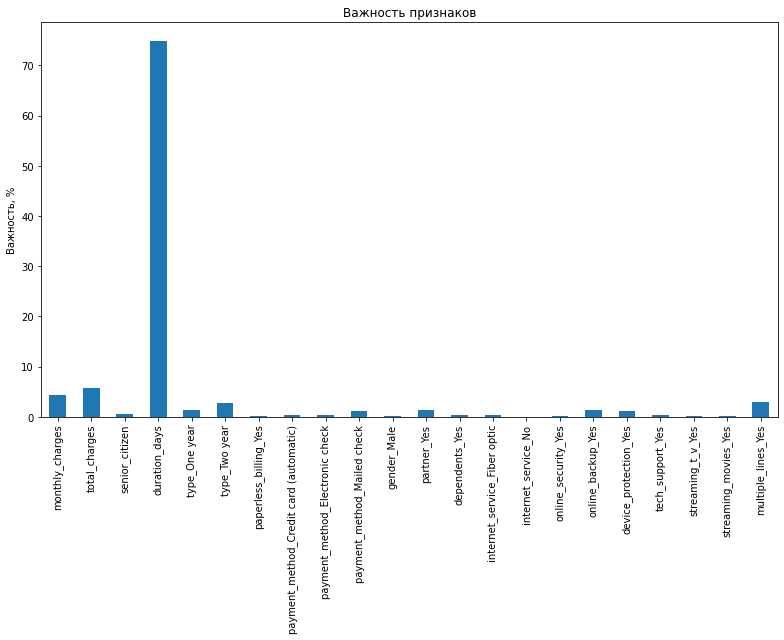

In [56]:
model = CatBoostClassifier(random_state=RANDOM_STATE, n_estimators = 100, max_depth = 2, learning_rate = 1)
model.fit(X_train, y_train)

cat_imp = pd.Series(model.get_feature_importance(), X_train.columns)
fig, ax = plt.subplots(figsize=(11,9))

cat_imp.plot.bar(ax=ax)
ax.set_title('Важность признаков')
ax.set_ylabel('Важность, %')
fig.tight_layout()
plt.savefig('my_plot.png', bbox_inches='tight') 

**Вывод:** 

Самый важный признак при обучении модели CatBoostClassifier дни пользования услугами клиента - примерно 75% важности. На втором месте по важности является столбец total_charges - всего потрачено денег на услуги - около 5%, и на третьем месте столбец monhthy_charges - ежемесячные траты на услуги - примерно 4%. Остальные признаки имеют ниже 3% по степени важности при обучении модели.

### Отчет по проекту "Прогнозирование оттока клиентов"

1. Все пункты плана были выполнены.

2. Ключевые шаги в решении задач: 
    - создание новых признаков, там же целевой признак;
    - предобработка данных, а именно работа с пропусками и удаление столбцов мешающих корректному обучению модели;
    - кодирование данных;
    - построение моделей с подбором оптимальных значений гиперпараметров;
    - оценка качества выбранной модели на тестовой выборке;
    - анализ выбранной модели, выделение важных признаков при обучении модели.
    
3. Модель CatBoostClassifier показала лучший результат метрики на обучающей и тестовой выборках:
    - ROC-AUC = 0.91 - на обучающей выборке;
    - ROC-AUC = 0.92 - на тестовой выборке.
    
    Для достижения этого результата использовались следующие параметры:
    - 'learning_rate': 1;
    - 'max_depth': 2;
    - 'n_estimators': 100.
    
4. Самый важный признак при обучении модели, это дни пользования услугами клиента - примерно 75% важности. На втором месте по важности является сколько всего потрачено денег на услуги - около 5%, и на третьем месте ежемесячные траты на услуги - примерно 4%. Остальные признаки имеют ниже 3% по степени важности при обучении модели.

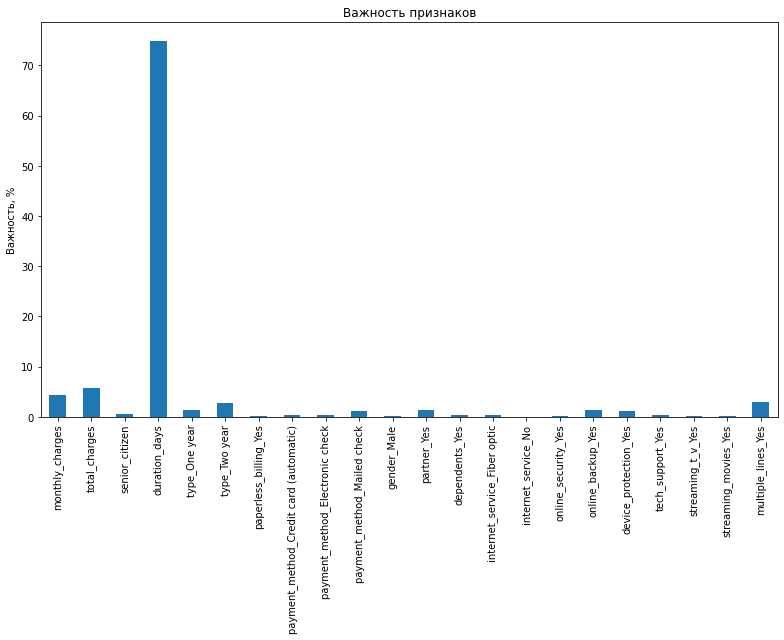

     Значения признаков на которых обучалась лучшая модель:
     - 'monthly_charges' - ежемесячные траты на услуги;
     - 'total_charges' - всего потрачено денег на услуги;
     - 'senior_citizen' - пенсионер;
     - 'duration_days' - количество дней пользования услугами;
     - 'type_One year' - тип договора (оплата за год);
     - 'type_Two year' - тип договора (оплата за 2 года);
     - 'paperless_billing_Yes' - факт выставления счета на эл-ую почту;
     - 'payment_method_Credit card (automatic)' - способ оплаты банковской карточкой;
     - 'payment_method_Electronic check' - способ оплаты электронный чек;
     - 'payment_method_Mailed check' - способ оплаты чек почтой;
     - 'gender_Male' - пол клиента (мужской);
     - 'partner_Yes' - наличие партнера;
     - 'dependents_Yes' - наличие иждивенцев;
     - 'internet_service_Fiber optic' - тип подключения интернета;
     - 'internet_service_No' - тип подключения интернета;
     - 'online_security_Yes' - блокировка небезопасных сайтов;
     - 'online_backup_Yes' - наличие облачного хранилища;
     - 'device_protection_Yes' - наличие антивируса;
     - 'tech_support_Yes' - наличие технической поддержки;
     - 'streaming_t_v_Yes' - наличие стримингового телевидения;
     - 'streaming_movies_Yes' - наличие каталога фильмов;
     - 'multiple_lines_Yes' - наличие возможности ведения параллельных линий во время звонка.
   